In [1]:
#import packages

# === PDF Extraction ===
import fitz
import pdfplumber
from tqdm import tqdm

# === File & OS ===
import os
import re
import glob

# === NLP Preprocessing ===
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from unidecode import unidecode
import emoji

# === Feature Extraction ===
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from gensim.models import Word2Vec
from sklearn.decomposition import NMF, TruncatedSVD
from transformers import pipeline

# === Dimensionality Reduction ===
from sklearn.decomposition import PCA
import umap
import umap.umap_ as umap
from sklearn.manifold import TSNE
import torch  # for autoencoders
from tensorflow import keras
from tensorflow.keras import layers, models

# === Clustering ===
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import hdbscan
from sklearn_extra.cluster import KMedoids
from scipy.cluster.hierarchy import dendrogram, linkage  # for visualizing hierarchy

# === Similarity & Metrics ===
from sklearn.metrics.pairwise import cosine_similarity

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import bokeh.plotting as bplt
from wordcloud import WordCloud
import networkx as nx

# === Utilities ===
import time
import joblib
import logging
import json
import openpyxl

import warnings
warnings.filterwarnings("ignore")

2025-07-12 23:38:41.127895: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Check nltk resources (first-time only)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Load spacy model
import spacy
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kimminjoo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kimminjoo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kimminjoo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/kimminjoo/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Load Data

In [3]:
#file_path = os.path.expanduser('~/Desktop/AI Xperience/unclassified_only_07_06_25.csv')
df = pd.read_csv('~/Desktop/AI Xperience/unclassified_only_07_06_25.csv')
df

Date    Focus Area   Subcategory  Jurisdiction       Context  \
0     2025-07-05  Unclassified  Unclassified  Unclassified  Unclassified   
1     2025-07-05  Unclassified  Unclassified  Unclassified  Unclassified   
2     2025-07-05  Unclassified  Unclassified  Unclassified  Unclassified   
3     2025-07-05  Unclassified  Unclassified  Unclassified  Unclassified   
4     2025-07-05  Unclassified  Unclassified  Unclassified  Unclassified   
...          ...           ...           ...           ...           ...   
7859  2025-07-05  Unclassified  Unclassified       Federal  Unclassified   
7860  2025-07-05  Unclassified  Unclassified  Unclassified  Unclassified   
7861  2025-07-05  Unclassified  Unclassified  Unclassified  Unclassified   
7862  2025-07-05  Unclassified  Unclassified  Unclassified  Unclassified   
7863  2025-07-05  Unclassified  Unclassified  Unclassified  Unclassified   

           AI Type        Source Geographic Context          Actionability  \
0     Unclassified  Unclassified       Unclassified           Unclassified   
1     Unclassified  Unclassified       Unclassified           Unclassified   
2     Unclassified  Unclassified       Unclassified           Unclassified   
3     Unclassified  Unclassified       Unclassified           Unclassified   
4     Unclassified  Unclassified       Unclassified           Unclassified   
...            ...           ...                ...                    ...   
7859  Unclassified  Unclassified       Unclassified  Actionable Governance   
7860  Unclassified  Unclassified       Unclassified           Unclassified   
7861  Unclassified    Government       Unclassified           Unclassified   
7862  Unclassified  Unclassified       Unclassified           Unclassified   
7863  Unclassified  Unclassified       Unclassified           Unclassified   

                                                    URL  \
0     https://www.hhs.gov/guidance/sites/default/fil...   
1     https://www.hhs.gov/sites/default/files/sharin...   
2     https://www.hhs.gov/sites/default/files/final-...   
3     https://www.hhs.gov/sites/default/files/depart...   
4     https://www.hhs.gov/sites/default/files/ohrp-e...   
...                                                 ...   
7859  https://dhhr.wv.gov/bms/Programs/WaiverProgram...   
7860  https://www.dhs.wisconsin.gov/arpa/hcbs-innova...   
7861  https://docs.legis.wisconsin.gov/misc/lfb/budg...   
7862  https://www.dhs.wisconsin.gov/publications/p02...   
7863  https://www.dhs.wisconsin.gov/clts/waiver/clts...   

                                                   Text  
0     Reference #18.a689cc17.1751725012.29d2f250 htt...  
1     Reference #18.a689cc17.1751725012.29d2f55f htt...  
2     Reference #18.a689cc17.1751725012.29d2f816 htt...  
3     Reference #18.a689cc17.1751725013.29d2fa46 htt...  
4     Reference #18.a689cc17.1751725013.29d2fcd9 htt...  
...                                                 ...  
7859  West Virginia Home and Community Based Service...  
7860  Wisconsin HCBS Innovation Grants Final Evaluat...  
7861  2025-27 Wisconsin State Budget March, 2025 LEG...  
7862  COVID-19 Vaccination Community Outreach Grant ...  
7863  Application for a §1915(c) Home and Community-...  

[7864 rows x 11 columns]

In [4]:
# I'm using shortened sample and texts to avoid crashing.
# We can skip this code if RAM is large enough.
# Change "df_sample" into "df" and "TextShort" into "Text" for the following codes if you want to run the codes using the whole dataset.

df["TextShort"] = df["Text"].str.slice(0, 100)
df_sample = df.sample(1000, random_state=42)

# 1. Clustering for Documents
### Preprocessing

In [5]:
#texts = df["Text"].dropna().tolist()
texts = df_sample["TextShort"].dropna().tolist()

nltk.download("stopwords")
nltk.download("wordnet")
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text.lower())
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]
    return " ".join(tokens)

texts_cleaned = [preprocess(t) for t in tqdm(texts)]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kimminjoo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kimminjoo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████| 1000/1000 [00:06<00:00, 156.74it/s]


### Feature Extraction + Dimensionality Reduction + Clustering

In [6]:
#Clustering 1

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(texts_cleaned)

# PCA
pca = PCA(n_components=50)
X_reduced = pca.fit_transform(X.toarray())

# K-Means Clustering
kmeans = KMeans(n_clusters=10, random_state=42)
labels = kmeans.fit_predict(X_reduced)

# Add back to DataFrame
df_sample["Cluster1"] = labels

In [7]:
# Clustering 2

# Sentence Transformers (Bert)
model = SentenceTransformer('all-MiniLM-L6-v2')
X = model.encode(texts_cleaned, show_progress_bar=True)

# UMAP
reducer = umap.UMAP(n_components=5, metric='cosine')
X_umap = reducer.fit_transform(X)

# HDBSCAN Clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, metric='euclidean')
labels = clusterer.fit_predict(X_umap)

df_sample["Cluster2"] = labels

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
# Clustering 3

# Sentence Transformers (Bert)
model = SentenceTransformer("all-MiniLM-L6-v2")
X = model.encode(texts_cleaned, show_progress_bar=True)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init="pca", learning_rate=200)
X_tsne = tsne.fit_transform(X)

# K-Means Clustering
kmeans = KMeans(n_clusters=10, random_state=42)
labels = kmeans.fit_predict(X_tsne)

df_sample["Cluster3"] = labels

### Visualization

In [9]:
# Clustering 1
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X)
df_sample["PCA1"] = X_2d[:, 0]
df_sample["PCA2"] = X_2d[:, 1]

fig = px.scatter(
    df_sample,
    x="PCA1", y="PCA2",
    color="Cluster1",
    hover_data=["TextShort"],
    title="TF-IDF + PCA + KMeans Clustering (2D)"
)
fig.show()

In [10]:
# Clustering 2
fig2 = px.scatter(
    x=X_umap[:len(df_sample), 0], y=X_umap[:len(df_sample), 1],
    color=df_sample["Cluster2"].astype(str),
    hover_data={"Text": df_sample["TextShort"]},
    title="Document Clustering with UMAP"
)
fig2.show()

In [11]:
# Clustering 3
fig3 = px.scatter(
    x=X_tsne[:len(df_sample), 0], y=X_tsne[:len(df_sample), 1],
    color=df_sample["Cluster3"].astype(str),
    hover_data={"Text": df_sample["TextShort"]},
    title="t-SNE + Clustering Visualization"
)
fig3.show()

In [12]:
# Check Top Words per Cluster
for i in sorted(df_sample["Cluster3"].unique()):
    cluster_texts = df_sample[df_sample["Cluster3"] == i]["Text"]
    print(f"\n🌀 Cluster {i}")
    print(cluster_texts.sample(1).values[0][:500])


🌀 Cluster 0
Developmental Disabilities Individual Budgeting Waiver Services Coverage and Limitations Handbook APPENDIX B IBUDGET TRAINING REQUIREMENTS FOR IBUDGET WAIVER PROVIDERS September 2015 B-1 Developmental Disabilities Individual Budgeting Waiver Services Coverage and Limitations Handbook IBUDGET TRAINING REQUIREMENTS FOR IBUDGET WAIVER PROVIDERS With the promulgation of this handbook, Agency for Persons with Disabilities (APD) provider training requirements are broken into three categories: Required

🌀 Cluster 1
Cerner Corporation Anuva Near Site Clinics Carey Wood Director, Sales Leader Population Health Services Dr. Gerry Stanley Chief Medical Officer Consumer & Employer Solutions Brian Glaves Sr. Strategic Client Executive Population Health Services In 2018, associates using the Healthe Clinics had a 16% lower PMPM than those associates using community providers in Kansas City In 2018, the Healthe Pharmacy had a 70% lower cost-per-day supply than the average community pharm

# 2. Clustering for Words
### Preprocessing

In [13]:
# Re-load data for word clustering
df = pd.read_csv('~/Desktop/AI Xperience/unclassified_only_07_06_25.csv')
df

Date    Focus Area   Subcategory  Jurisdiction       Context  \
0     2025-07-05  Unclassified  Unclassified  Unclassified  Unclassified   
1     2025-07-05  Unclassified  Unclassified  Unclassified  Unclassified   
2     2025-07-05  Unclassified  Unclassified  Unclassified  Unclassified   
3     2025-07-05  Unclassified  Unclassified  Unclassified  Unclassified   
4     2025-07-05  Unclassified  Unclassified  Unclassified  Unclassified   
...          ...           ...           ...           ...           ...   
7859  2025-07-05  Unclassified  Unclassified       Federal  Unclassified   
7860  2025-07-05  Unclassified  Unclassified  Unclassified  Unclassified   
7861  2025-07-05  Unclassified  Unclassified  Unclassified  Unclassified   
7862  2025-07-05  Unclassified  Unclassified  Unclassified  Unclassified   
7863  2025-07-05  Unclassified  Unclassified  Unclassified  Unclassified   

           AI Type        Source Geographic Context          Actionability  \
0     Unclassified  Unclassified       Unclassified           Unclassified   
1     Unclassified  Unclassified       Unclassified           Unclassified   
2     Unclassified  Unclassified       Unclassified           Unclassified   
3     Unclassified  Unclassified       Unclassified           Unclassified   
4     Unclassified  Unclassified       Unclassified           Unclassified   
...            ...           ...                ...                    ...   
7859  Unclassified  Unclassified       Unclassified  Actionable Governance   
7860  Unclassified  Unclassified       Unclassified           Unclassified   
7861  Unclassified    Government       Unclassified           Unclassified   
7862  Unclassified  Unclassified       Unclassified           Unclassified   
7863  Unclassified  Unclassified       Unclassified           Unclassified   

                                                    URL  \
0     https://www.hhs.gov/guidance/sites/default/fil...   
1     https://www.hhs.gov/sites/default/files/sharin...   
2     https://www.hhs.gov/sites/default/files/final-...   
3     https://www.hhs.gov/sites/default/files/depart...   
4     https://www.hhs.gov/sites/default/files/ohrp-e...   
...                                                 ...   
7859  https://dhhr.wv.gov/bms/Programs/WaiverProgram...   
7860  https://www.dhs.wisconsin.gov/arpa/hcbs-innova...   
7861  https://docs.legis.wisconsin.gov/misc/lfb/budg...   
7862  https://www.dhs.wisconsin.gov/publications/p02...   
7863  https://www.dhs.wisconsin.gov/clts/waiver/clts...   

                                                   Text  
0     Reference #18.a689cc17.1751725012.29d2f250 htt...  
1     Reference #18.a689cc17.1751725012.29d2f55f htt...  
2     Reference #18.a689cc17.1751725012.29d2f816 htt...  
3     Reference #18.a689cc17.1751725013.29d2fa46 htt...  
4     Reference #18.a689cc17.1751725013.29d2fcd9 htt...  
...                                                 ...  
7859  West Virginia Home and Community Based Service...  
7860  Wisconsin HCBS Innovation Grants Final Evaluat...  
7861  2025-27 Wisconsin State Budget March, 2025 LEG...  
7862  COVID-19 Vaccination Community Outreach Grant ...  
7863  Application for a §1915(c) Home and Community-...  

[7864 rows x 11 columns]

In [14]:
# Preprocessing for tokens
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = re.sub(r"[^a-zA-Z]", " ", text.lower())
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 2]
    return tokens

# Truncate and process in batches
# I'm using shortened texts here as well to avoid crashing.
tokenized_texts = []
texts = df["Text"].dropna().str.slice(0, 500).tolist()

for i in tqdm(range(0, len(texts), 500)):
    batch = texts[i:i+500]
    batch_tokens = [preprocess(t) for t in batch]
    tokenized_texts.extend(batch_tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kimminjoo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kimminjoo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████| 16/16 [00:04<00:00,  3.90it/s]


### Feature Extraction + Dimensionality Reduction + Clustering

In [15]:
# Use Word2Vec for feature extraction for all 3 DR methods
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=5, workers=4)
word_vectors = w2v_model.wv
words = word_vectors.index_to_key
vectors = word_vectors.vectors

In [16]:
# Clustering 1: PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(vectors)
kmeans_pca = KMeans(n_clusters=20, random_state=42).fit(X_pca)
labels_pca = kmeans_pca.labels_

# Clustering 2: UMAP
umap_model = umap.UMAP(n_components=2, metric='cosine')
X_umap = umap_model.fit_transform(vectors)
kmeans_umap = KMeans(n_clusters=20, random_state=42).fit(X_umap)
labels_umap = kmeans_umap.labels_

# Clustering 3: t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init="pca", learning_rate=200)
X_tsne = tsne.fit_transform(vectors)
kmeans_tsne = KMeans(n_clusters=20, random_state=42).fit(X_tsne)
labels_tsne = kmeans_tsne.labels_

### Visualization

In [17]:
words_df = pd.DataFrame({"word": words})

words_df_pca = words_df.copy()
words_df_pca["x"] = X_pca[:, 0]
words_df_pca["y"] = X_pca[:, 1]
words_df_pca["cluster"] = labels_pca

words_df_umap = words_df.copy()
words_df_umap["x"] = X_umap[:, 0]
words_df_umap["y"] = X_umap[:, 1]
words_df_umap["cluster"] = labels_umap

words_df_tsne = words_df.copy()
words_df_tsne["x"] = X_tsne[:, 0]
words_df_tsne["y"] = X_tsne[:, 1]
words_df_tsne["cluster"] = labels_tsne

fig_pca = px.scatter(words_df_pca, x="x", y="y", color=words_df_pca["cluster"].astype(str), hover_data=["word"], title="Word Clustering: PCA + KMeans")
fig_umap = px.scatter(words_df_umap, x="x", y="y", color=words_df_umap["cluster"].astype(str), hover_data=["word"], title="Word Clustering: UMAP + KMeans")
fig_tsne = px.scatter(words_df_tsne, x="x", y="y", color=words_df_tsne["cluster"].astype(str), hover_data=["word"], title="Word Clustering: t-SNE + KMeans")

fig_pca.show()
fig_umap.show()
fig_tsne.show()

In [18]:
clustered_words = words_df_tsne  # or words_df_pca, words_df_umap

# Print top 20 words for each cluster
num_words = 20

for cluster_id in sorted(clustered_words["cluster"].unique()):
    top_words = clustered_words[clustered_words["cluster"] == cluster_id]["word"]
    print(f"\n🔹 Cluster {cluster_id}:")
    print(", ".join(top_words.head(num_words).tolist()))


🔹 Cluster 0:
student, team, expert, global, manager, consumer, within, regulatory, result, adoption, academic, experience, licensure, addressing, aging, perspective, discussion, iowa, important, funded

🔹 Cluster 1:
iac, performing, annotated, feature, uni, hear, ptac, unaware, icd, ita, faq, regard, articulation, decisio, granted, privilege, expected, remediation, jurisdiction, brets

🔹 Cluster 2:
press, wmc, wyoming, sacramento, purchasing, rouge, baton, towson, dallas, russell, tallahassee, pritzker, ste, nuclear, dept, rai, dentistry, zip, columbus, montgomery

🔹 Cluster 3:
office, page, technology, http, education, gov, board, error, government, net, american, edgesuite, website, science, nist, www, date, please, prepared, june

🔹 Cluster 4:
international, llc, con, abstract, lead, ahca, med, via, good, hospice, reed, chicago, judicial, brian, debra, peter, issn, charter, austin, deaf

🔹 Cluster 5:
deadline, posted, news, compiled, participate, pleasure, corresponding, cvmwom, ma

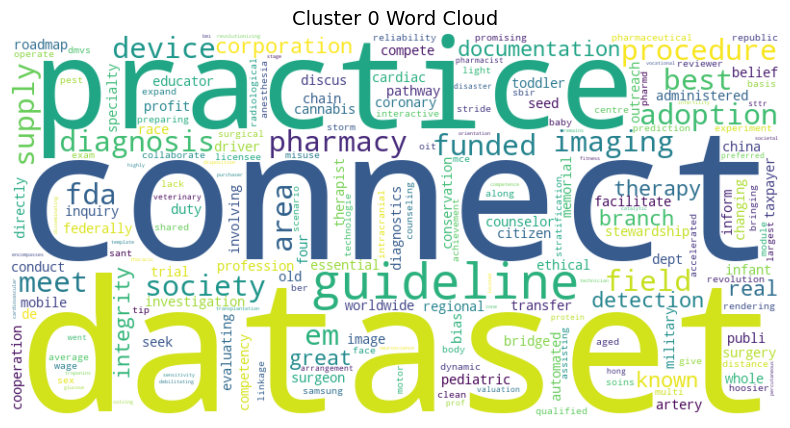

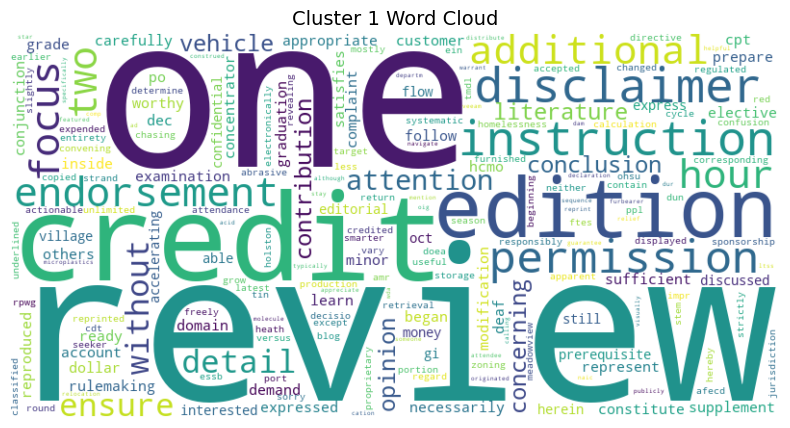

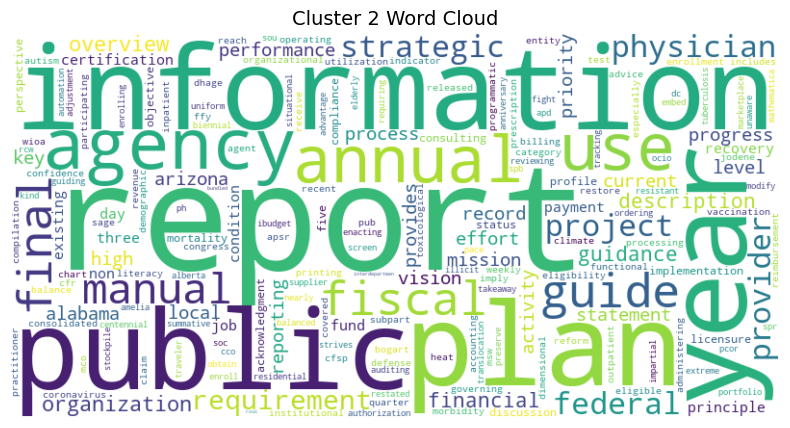

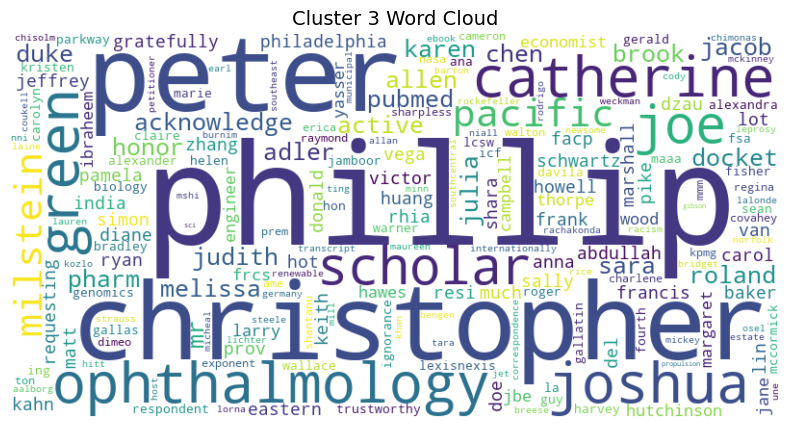

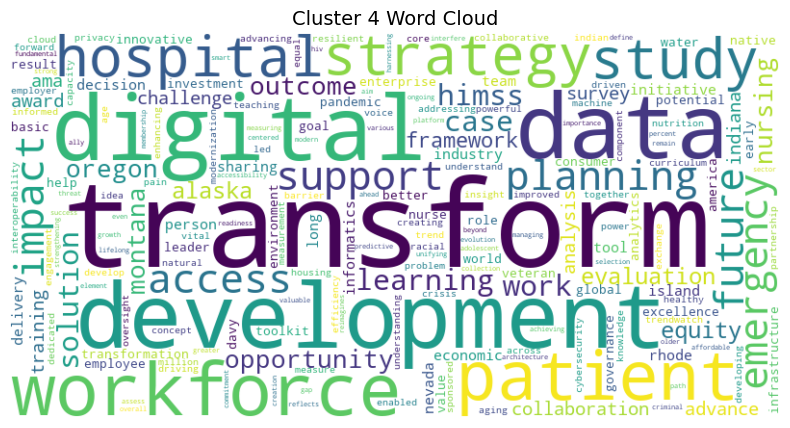

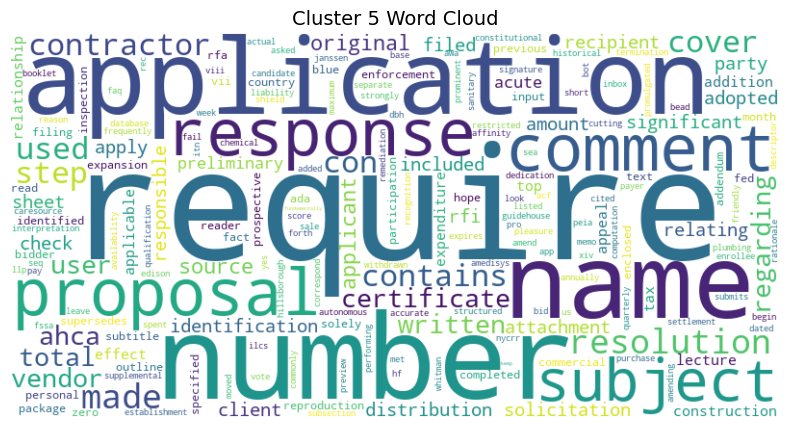

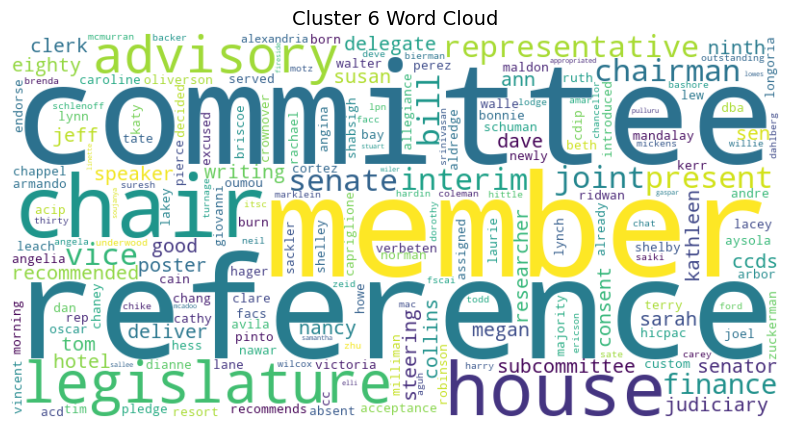

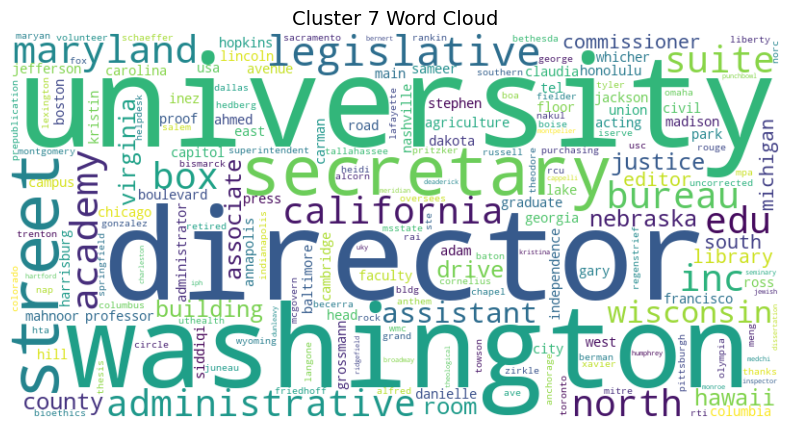

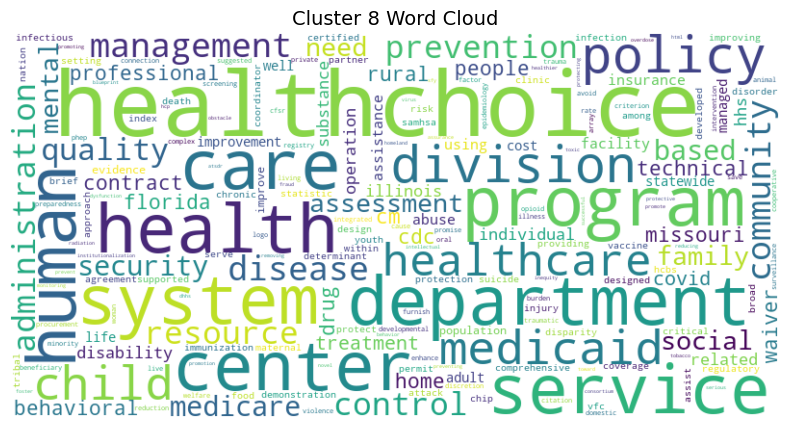

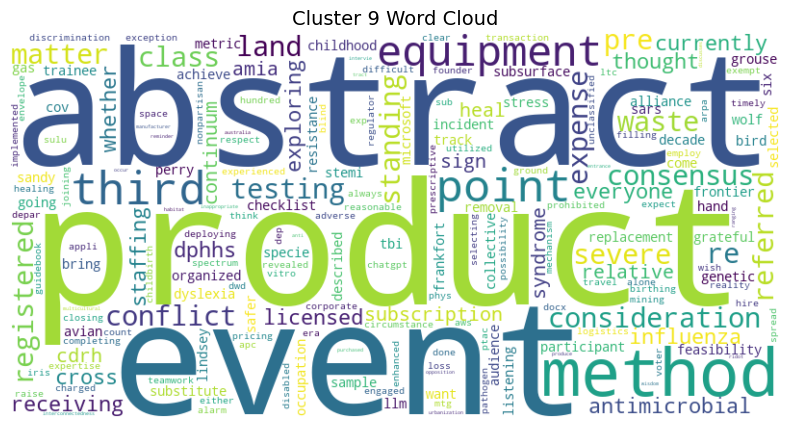

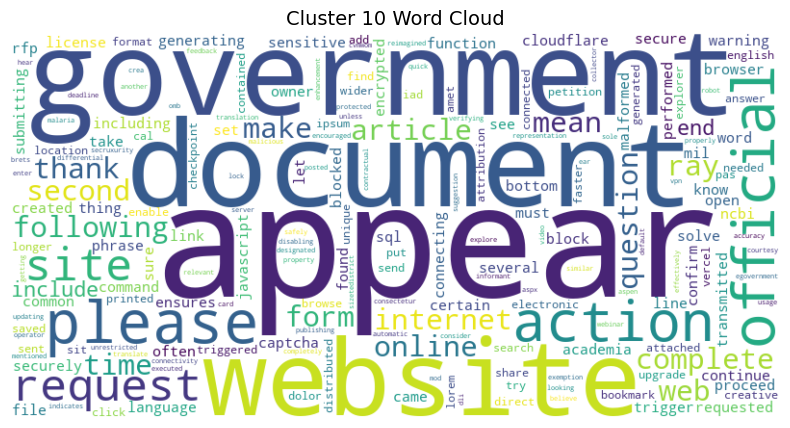

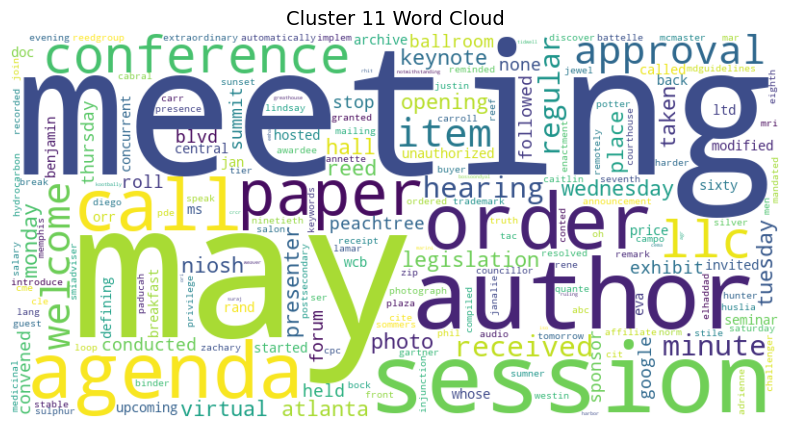

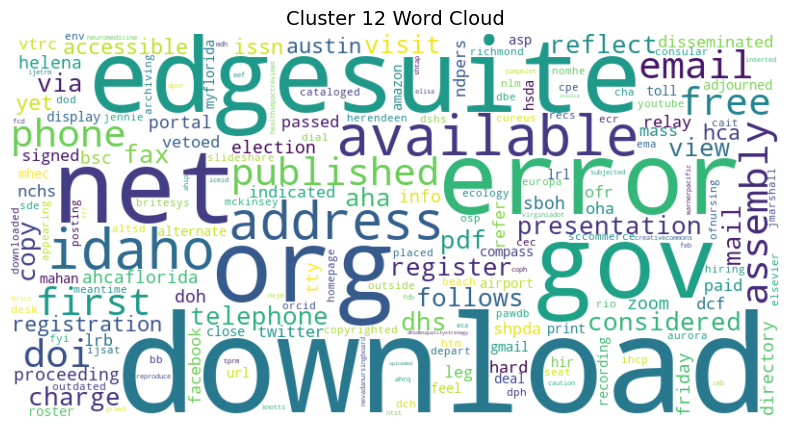

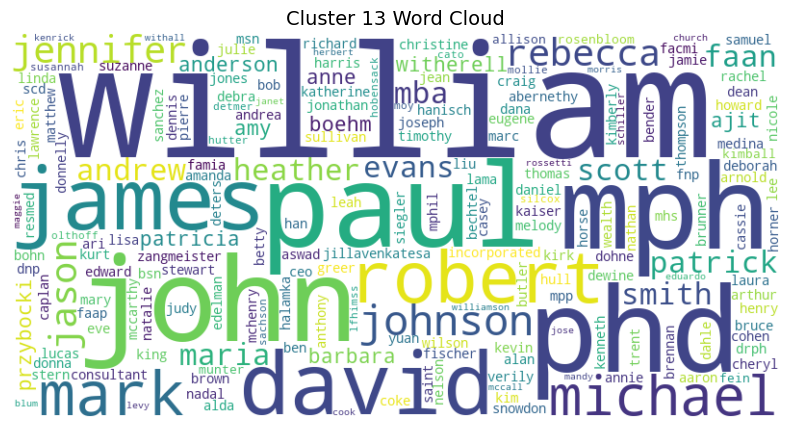

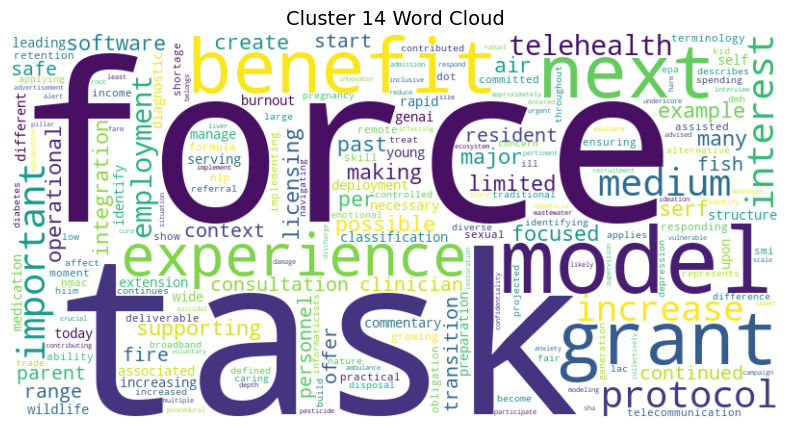

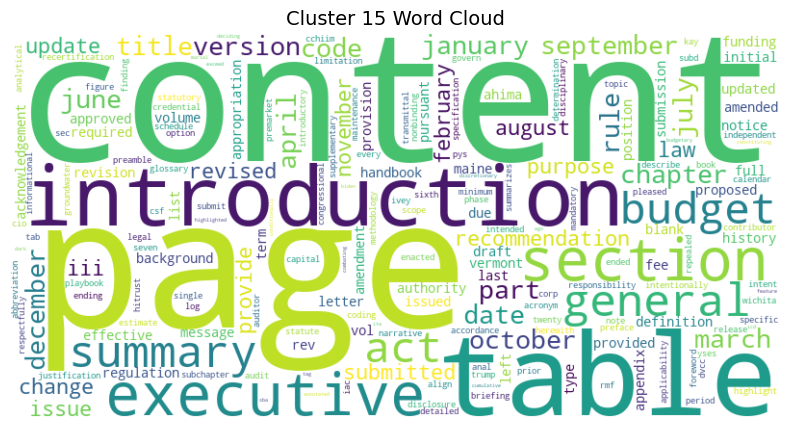

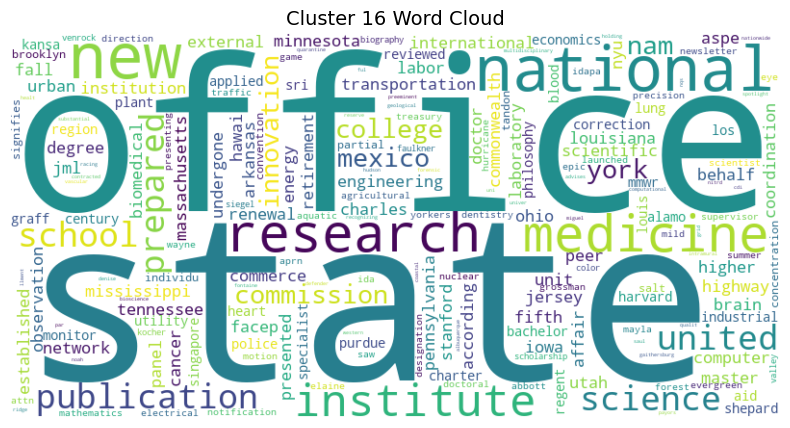

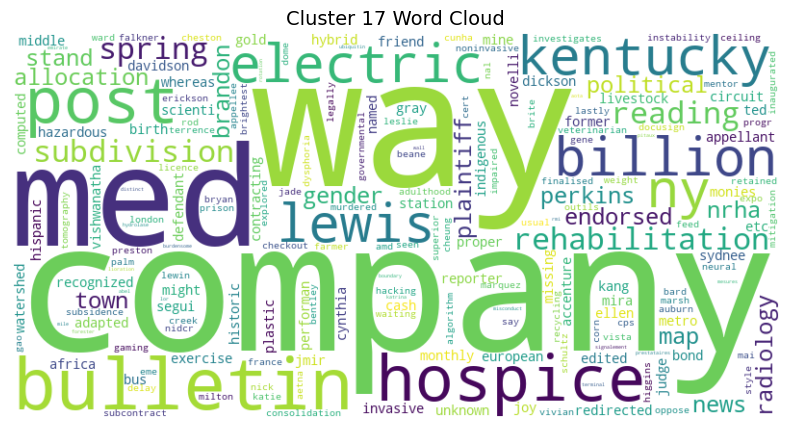

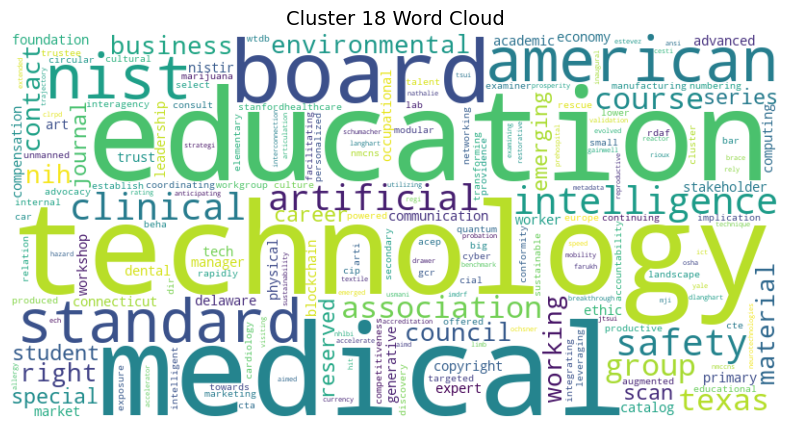

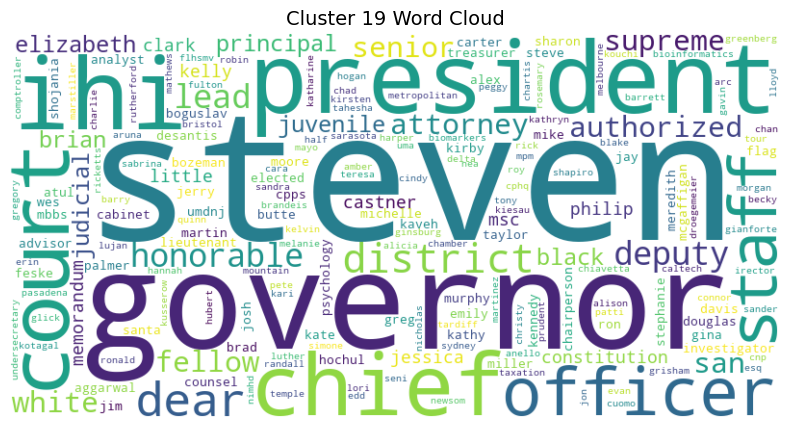

In [19]:
# Generate word clouds for all clusters
clustered_words = words_df_umap  # or words_df_tsne / words_df_pca
unique_clusters = sorted(clustered_words["cluster"].unique())

for cluster_id in unique_clusters:
    word_list = clustered_words[clustered_words["cluster"] == cluster_id]["word"].tolist()
    text = " ".join(word_list)
    
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Cluster {cluster_id} Word Cloud", fontsize=14)
    plt.show()